In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from pprint import pprint
from collections import OrderedDict
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_dataset import k12ai_compute_mean_std

## 标签含义

标签(lable) | 含义
:----:|:----:
<img width=200/>|<img width=200/>
0 | 0
1 | 1
2 | 2
3 | 3
4 | 4
5 | 5
6 | 6
7 | 7
8 | 8
9 | 9

## 精简

In [3]:
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rmnist')

train_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist', 'train.json')
valid_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist', 'val.json')
items = []
with open(train_json) as f:
    items_1 = json.load(f)
    items.extend(items_1)
    
with open(valid_json) as f:
    items_2 = json.load(f)
    items.extend(items_2)
    
len(items_1), len(items_2), len(items)

(48000, 12000, 60000)

### 读取

In [4]:
# df = pd.read_json("train.json",encoding="utf-8", orient='records')
df = pd.json_normalize(items)
df[:5]

,image_path,label
0,imgs/train/12787.jpg,7
1,imgs/train/01713.jpg,8
2,imgs/train/54872.jpg,6
3,imgs/train/24758.jpg,8
4,imgs/train/50993.jpg,3


### 查看是否均匀分布

In [5]:
grouped_by_label = df.groupby('label')
grouped_by_label.count()
# grouped_by_label.p

,image_path
label,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


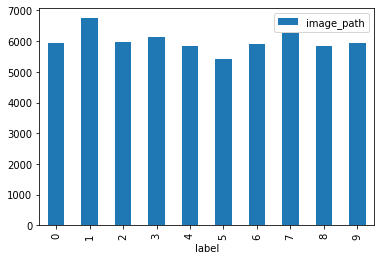

In [6]:
grouped_by_label.count().plot(kind='bar');

### 随机精简

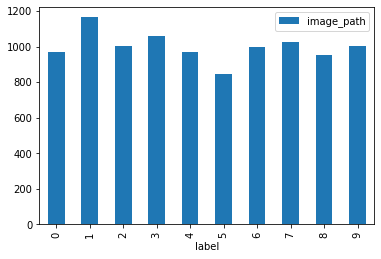

In [7]:
# 不合理: 不平衡的样本
reduced_grouped_by_label = df.sample(n=10000, random_state=10, ).groupby('label')
reduced_grouped_by_label.count().plot(kind='bar');

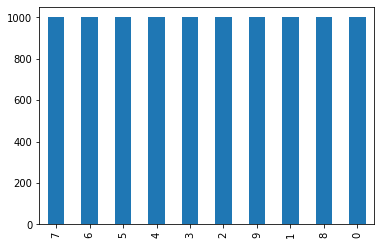

In [8]:
# 合理: 先分组, 然后组中随机样本
reduced_df = df.groupby('label').apply(pd.DataFrame.sample, n=1000, random_state=10, replace=False)
reduced_df['label'].value_counts().plot(kind='bar');

### 对样本随机打散

In [9]:
df[df['image_path'] == "imgs/train/21265.jpg"]

,image_path,label
9127,imgs/train/21265.jpg,3


In [10]:
reduced_shuffle_df = reduced_df.sample(frac=1)
reduced_shuffle_df[:5]

image_path  label
label                                   
9     34887  imgs/train/00796.jpg      9
      53423  imgs/train/11762.jpg      9
6     50701  imgs/train/11794.jpg      6
2     32393  imgs/train/34109.jpg      2
8     56383  imgs/train/08359.jpg      8

### 分割数据集6:2:2

In [11]:
train_valid_df, test_df = train_test_split(reduced_shuffle_df, test_size=0.2)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2)
all_count = len(reduced_shuffle_df)
train_count, val_count, test_count = len(train_df), len(valid_df), len(test_df)
train_count, val_count, test_count, all_count

(6400, 1600, 2000, 10000)

## 保存精简数据集rmnist

In [12]:
def generate_rmnist(df, phase):
    src_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist')
    dst_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rmnist')
    
    img_path = os.path.join(dst_root, 'imgs', phase)
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(img_path)
    
    results = []
    items = df.to_dict(orient='records')
    print(f'{phase} count: {len(items)}')
    for item in items:
        filename = os.path.basename(item['image_path'])
        src_path = os.path.join(src_root, item['image_path'])
        dst_path = os.path.join(img_path, filename)
        if not os.path.exists(src_path):
            print('not found:', src_path)
        if os.path.exists(dst_path):
            print('replce found:', dst_path)
        results.append({
            'image_path': f'imgs/{phase}/{filename}',
            'label': item['label']
        })
        shutil.copy2(src_path, dst_path)
        
    with open(os.path.join(dst_root, f'{phase}.json'), 'w') as f:
        json.dump(results, f)
    return len(result) 
        
generate_rmnist(test_df, 'test');
generate_rmnist(train_df, 'train');
generate_rmnist(valid_df, 'val');

test count: 2000
train count: 6400
val count: 1600


## 生成info.json

In [13]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles)

In [18]:
info = {
    'num_records': all_count,
    'num_classes': 10,
    'label_names': [
        '0',
        '1',
        '2',
        '3',
        '4',
        '5',
        '6',
        '7',
        '8',
        '9'
    ],
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
   
info

{'num_records': 10000,
 'num_classes': 10,
 'label_names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'mean': [0.1362, 0.1362, 0.1362],
 'std': [0.2893, 0.2893, 0.2893]}

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

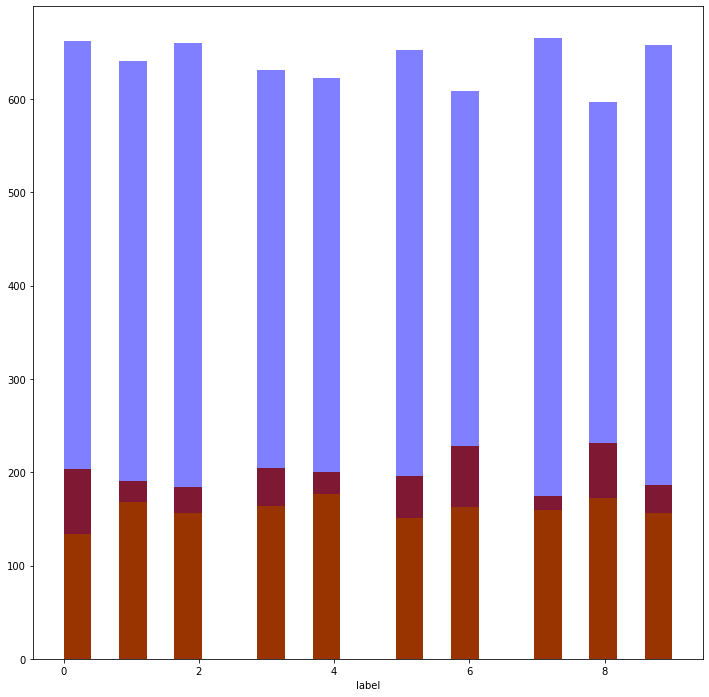

In [16]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'maroon', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()